# Import libraries and data


In [2]:
%cd D://Flood Risk Churn-MF/Evaluacion del dataset 25001 para validacion de articulo/25001

D:\Flood Risk Churn-MF\Evaluacion del dataset 25001 para validacion de articulo\25001


C:\Users\ZM\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 4.2 MB/s eta 0:00:30
    --------------------------------------- 1.8/124.9 MB 5.9 MB/s eta 0:00:21
   - -------------------------------------- 3.4/124.9 MB 6.5 MB/s eta 0:00:19
   - -------------------------------------- 4.7/124.9 MB 7.0 MB/s eta 0:00:18
   -- ------------------------------------- 6.6/124.9 MB 7.1 MB/s eta 0:00:17
   -- ------------------------------------- 8.4/124.9 MB 7.3 MB/s eta 0:00:16
   --- ------------------------------------ 10.5/124.9 MB 7.8 MB/s eta 0:00:15
   ---- ----------------------------------- 12.6/124.9 MB 8.0 MB/s eta 0:00:14
   ---- ----------------------------------- 14.2/124.9 MB 8.0 MB/s eta 0:00:14
   ----- ---------------------------------- 15.7/124.9 MB 8.0 MB/s eta 0:00:14
   ----- ---------------------------------- 17.0/124.9 MB 7.9 MB/s eta 0:00:14
   ------ --------------------------------- 19.1/124.9 MB 8.1 MB/s

In [3]:
#import libraries
import xgboost as xgb
import itertools
import pandas as pd
import numpy as np

In [4]:
#import libraries
import pandas as pd
import tensorflow_probability as tfp
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
dark_style={
 'figure.facecolor':'#212946',
 'axes.facecolor':'#212946',
 'savefig.facecolor':'#212946',
 'axes.grid':True,
 'axes.grid.which':'both',
 'axes.spines.top':False,
 'axes.spines.bottom':False,
 'grid.color':'#2A3459',
 'grid.linewidth':'1',
 'text.color':'0.9',
 'axes.labelcolor':'0.9',
 'xtick.color':'0.9',
 'ytick.color':'0.9',
 'font.size':12
}
plt.rcParams.update(dark_style)

In [5]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS
from sktime.utils.plotting import plot_series

In [4]:
#get the data
data = pd.read_csv("25001_61_71.csv",
                   index_col="FECHA",
                   parse_dates=True)
data.head(5)

,PRECIP,EVAP,TMAX,TMIN,FECHA_AUX
FECHA,,,,,
01/01/1961,1.0,5.0,25.0,13.0,01/01/1961
02/01/1961,1.0,5.0,27.5,14.0,02/01/1961
03/01/1961,1.0,5.0,31.0,11.0,03/01/1961
04/01/1961,1.0,5.0,32.0,13.0,04/01/1961
05/01/1961,1.0,5.0,29.0,14.0,05/01/1961


#Data Transformation

In [5]:
data.index = pd.to_datetime(data.index,
                            format = "%d/%m/%Y")
data.head(2)   
data = data.asfreq("MS")
data.index   

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01',
               ...
               '1971-03-01', '1971-04-01', '1971-05-01', '1971-06-01',
               '1971-07-01', '1971-08-01', '1971-09-01', '1971-10-01',
               '1971-11-01', '1971-12-01'],
              dtype='datetime64[ns]', name='FECHA', length=132, freq='MS')

In [6]:
data.index.year

Index([1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961,
       ...
       1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971],
      dtype='int32', name='FECHA', length=132)

In [7]:
def metricas(y_true,y_pred,model_name):
    mae_=mean_absolute_error(y_true,y_pred)
    rmse_=mean_squared_error(y_true,y_pred,square_root=True)
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    smape_=mean_absolute_percentage_error(y_true,y_pred,symmetric=True)
    dict_={'MAE':mae_,'RMSE_':rmse_,'MAPE':mape_,'SMAPE':smape_}
    metrica1=pd.DataFrame(dict_,index=[model_name])
    return(metrica1.round(decimals=2))

In [8]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['EVAP'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['EVAP'],test_size=36)
y_train.head(10)

FECHA
1961-01-01    5.0
1961-02-01    5.0
1961-03-01    5.0
1961-04-01    6.6
1961-05-01    8.0
1961-06-01    9.3
1961-07-01    4.9
1961-08-01    1.8
1961-09-01    2.9
1961-10-01    3.6
Freq: MS, Name: EVAP, dtype: float64

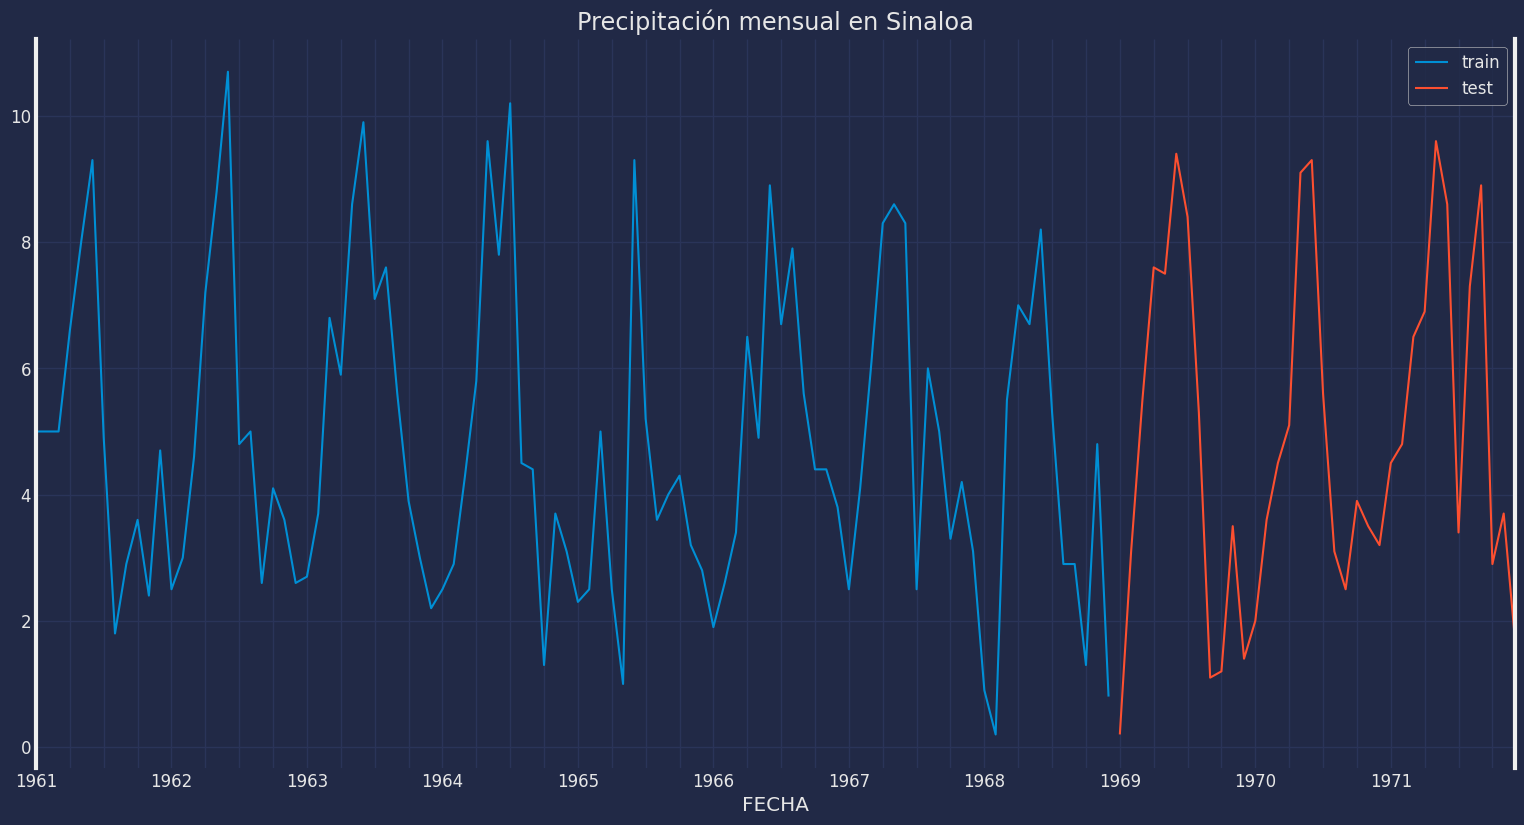

In [11]:
# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(17, 9))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
ax.set_title('Precipitación mensual en Sinaloa')
ax.legend();

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -1.977682932216261, p-value: 0.29644325738389987
KPSS Statistic: 0.04031473722157162, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -8.036214914779366, p-value: 1.8996583425940935e-12
KPSS Statistic: 0.022945321403879896, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -7.67190897241612, p-value: 1.585410928944424e-11
KPSS Statistic: 0.23574256317142345, p-value: 0.1


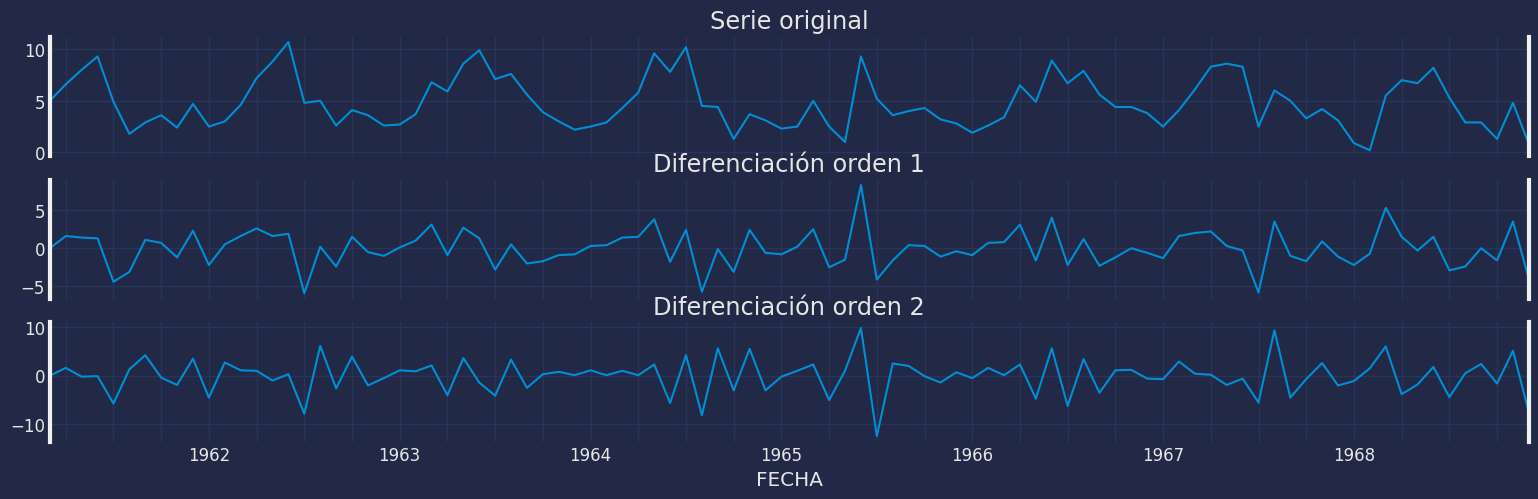

In [23]:
# Test estacionariedad
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")

datos_diff_1 = y_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(data['EVAP'])
kpss_result = kpss(data['EVAP'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(data['EVAP'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(data['EVAP'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(17, 5), sharex=True)
data['EVAP'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');



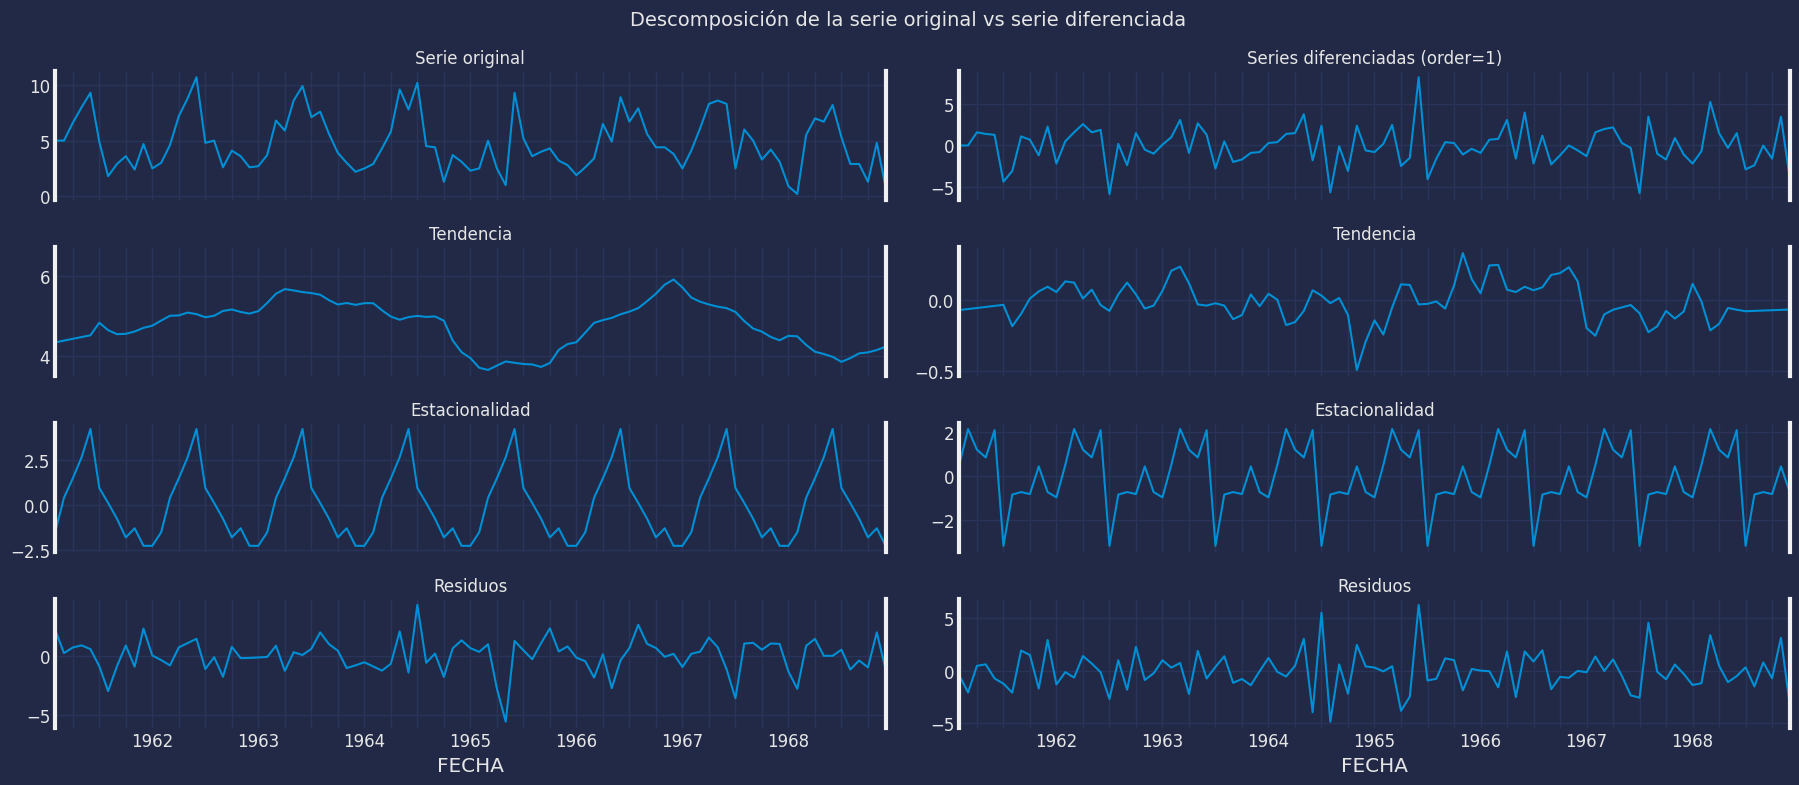

In [25]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
#library
from statsmodels.tsa.seasonal import seasonal_decompose
res_decompose = seasonal_decompose(data['EVAP'], model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 8), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

In [26]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = y_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -6.817253521373524, p-value: 2.044205127208005e-09
KPSS Statistic: 0.20338269583911134, p-value: 0.1


In [11]:
#get the data
data = pd.read_csv("25001_mens.csv",
                   index_col="FECHA",
                   parse_dates=True)
data.head(5)
#select variables
dataset = data.loc[:, ["Year","Month","EVAP","PRECIP","TMAX","TMIN"]]
dataset.head(1)   

rango = dataset[dataset.Year.isin( [1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972])]
rango.head()

,Year,Month,EVAP,PRECIP,TMAX,TMIN
FECHA,,,,,,
1962-01-01,1962,1,2.845161,5.0,34.5,4.5
1962-01-02,1962,2,4.028571,0.0,34.5,6.5
1962-01-03,1962,3,5.867742,1.4,37.5,4.5
1962-01-04,1962,4,7.900000,0.0,42.0,5.5
1962-01-05,1962,5,8.764516,0.0,41.5,14.0


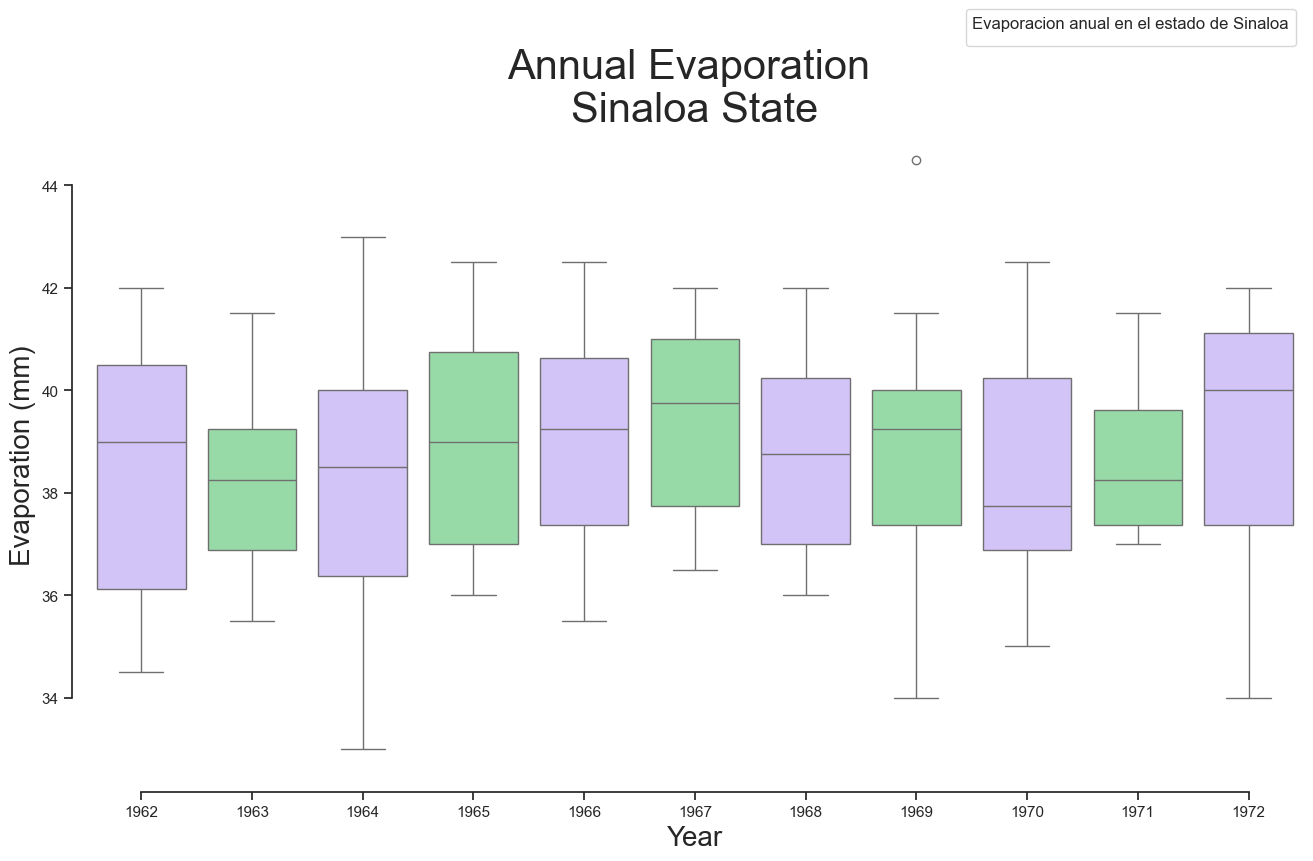

In [66]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(14,8))

# Draw a nested boxplot to show bills by day and time
plt.legend(title="Evaporacion anual en el estado de Sinaloa",bbox_to_anchor=(1, 1.2),fontsize='medium')
ax=sns.boxplot(x="Year", y="TMAX",
            palette=["m", "g"],
            data=rango)
ax.set_title('Annual Evaporation \nSinaloa State',fontsize=30)
ax.set_xlabel("Year",fontsize=20)
ax.set_ylabel("Evaporation (mm)",fontsize=20)
#plt.legend(labels=["Legend_Day1", "Legend_Day2"], title="Title_Legend")
sns.despine(offset=10, trim=True)


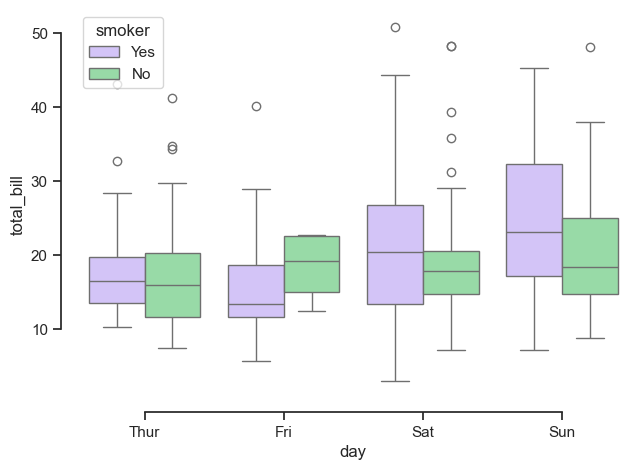

In [22]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)

In [20]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [88]:
for year in range(1962, 1972):
    data_boxplot.append(data.loc[(data.index.year == year)]['TMAX'])
data_boxplot

[FECHA
 1962-12-31    33.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1963-12-31    29.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1964-12-31    31.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1965-12-31    33.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1966-12-31    28.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1967-12-31    21.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1968-12-31    20.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1969-12-31    26.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1970-12-31    33.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1971-12-31    31.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1962-12-31    33.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1963-12-31    29.5
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1964-12-31    31.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1965-12-31    33.0
 Freq: YE-DEC, Name: TMAX, dtype: float64,
 FECHA
 1966-12-31  

In [ ]:
  
import seaborn as sns
plt.figure(figsize=(8,5))
ax = plt.gca()
sns.boxplot(data=data_boxplot, color='w', whis=1.5)
ax.set_xlabel('Year')
ax.set_ylabel('Car Count for Clear Days Only');
# plt.boxplot(data_boxplot, whis=1.5, showfliers=True);   
# use seaborn over matplotlib since matplotlib is not showing outliers, annoyingly

In [10]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 20,
            holidays_prior_scale = 20,
            changepoint_prior_scale = 0.01)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

#forecasting 

In [11]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [12]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [13]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2428.959073,222.633419,2219.733906,2428.959073,2428.959073,-0.055485,-0.055485,-0.055485,-0.279300,-0.279300,-0.279300,0.0,0.0,0.0,0.0,0.0,0.0,-0.070485,-0.070485,-0.070485,-0.483167,-0.483167,-0.483167,-0.089004,-0.089004,-0.089004,-0.084177,-0.084177,-0.084177,0.058168,0.058168,0.058168,0.019851,0.019851,0.019851,0.000000,0.000000,0.000000,-0.262035,-0.262035,-0.262035,0.0,0.0,0.0,1255.366957
1,2011-01-02,2434.578651,46.373431,1975.128624,2434.578651,2434.578651,-0.060155,-0.060155,-0.060155,-0.288027,-0.288027,-0.288027,0.0,0.0,0.0,0.0,0.0,0.0,-0.027599,-0.027599,-0.027599,-0.585264,-0.585264,-0.585264,-0.078185,-0.078185,-0.078185,-0.084177,-0.084177,-0.084177,-0.041308,-0.041308,-0.041308,-0.037911,-0.037911,-0.037911,0.000000,0.000000,0.000000,-0.255930,-0.255930,-0.255930,0.0,0.0,0.0,1009.706277
2,2011-01-03,2440.198229,384.066357,2268.729344,2440.198229,2440.198229,-0.137785,-0.137785,-0.137785,-0.188057,-0.188057,-0.188057,0.0,0.0,0.0,0.0,0.0,0.0,0.073537,0.073537,0.073537,-0.462290,-0.462290,-0.462290,-0.171815,-0.171815,-0.171815,0.052537,0.052537,0.052537,-0.025655,-0.025655,-0.025655,-0.037760,-0.037760,-0.037760,0.033228,0.033228,0.033228,-0.248577,-0.248577,-0.248577,0.0,0.0,0.0,1312.120106
3,2011-01-04,2445.817807,510.264658,2417.792074,2445.817807,2445.817807,-0.127053,-0.127053,-0.127053,-0.177430,-0.177430,-0.177430,0.0,0.0,0.0,0.0,0.0,0.0,0.013686,0.013686,0.013686,-0.418997,-0.418997,-0.418997,-0.169778,-0.169778,-0.169778,0.052537,0.052537,0.052537,-0.001477,-0.001477,-0.001477,0.019950,0.019950,0.019950,0.033228,0.033228,0.033228,-0.240090,-0.240090,-0.240090,0.0,0.0,0.0,1421.028542
4,2011-01-05,2451.437386,642.496537,2542.458811,2451.437386,2451.437386,-0.118953,-0.118953,-0.118953,-0.111696,-0.111696,-0.111696,0.0,0.0,0.0,0.0,0.0,0.0,0.073660,0.073660,0.073660,-0.347872,-0.347872,-0.347872,-0.154674,-0.154674,-0.154674,0.052537,0.052537,0.052537,-0.005576,-0.005576,-0.005576,0.002506,0.002506,0.002506,0.033228,0.033228,0.033228,-0.230600,-0.230600,-0.230600,0.0,0.0,0.0,1598.652066


#XGBoost preparation

In [14]:
prophet_variables = forecast.loc[:, ["trend", "holi", "weekly", "yearly"]]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2428.959073,0.0,0.058168,-0.262035
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2434.578651,0.0,-0.041308,-0.255930
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2440.198229,0.0,-0.025655,-0.248577
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2445.817807,0.0,-0.001477,-0.240090
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2451.437386,0.0,-0.005576,-0.230600


In [15]:
#Training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846,6422.673967,0.0,-0.025655,-0.264591


In [16]:
#isolate X and Y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [19]:
#create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

#XGBoost

In [21]:
#Set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [22]:
#XGBoost Model
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[0]	y-rmse:3891.59
[15]	y-rmse:1607.49
[30]	y-rmse:1368.37
[45]	y-rmse:1290.71
[60]	y-rmse:1252.2
[75]	y-rmse:1212.15
[90]	y-rmse:1199.75
[99]	y-rmse:1179.15


#Forecasting and Visualization

In [26]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name = "XGBoost")
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    4020.162598
2012-12-02    3019.301025
Name: XGBoost, dtype: float32

In [27]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

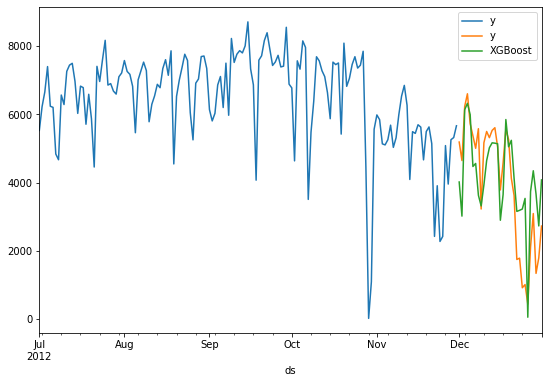

In [31]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

#Model assessment

In [32]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))

954.0
1179.0


In [33]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

45.99199599293936

#export forecasts

In [34]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [35]:
predictions_xgb.to_csv('predictions_xgb.csv', index = True)